# Single Cell Optimisation Tutorial

____________


Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Werner Van Geit @ Blue Brain Project

___
### Overview:

* In this exercise we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/) and to constrain the model parameters with experimental data.
___

We first import some useful Python modules.

In [1]:
%load_ext autoreload
%autoreload

import numpy
import json
import IPython, os
from json2html import *

import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 6, 6

import collections

import efel

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import neurom
from neurom import viewer 

import pprint
pp = pprint.PrettyPrinter(indent=2)

# 1. Model definition
In this section we will define the neuron model **template** (morphology and ionic currents) and the parameters that we will optimize later on.

First of all, we load and visualise the morphology with the [NeuroM](https://github.com/BlueBrain/NeuroM/) and we use BluePyOpt *ephys* module to load the morphology.

<IPython.core.display.Javascript object>


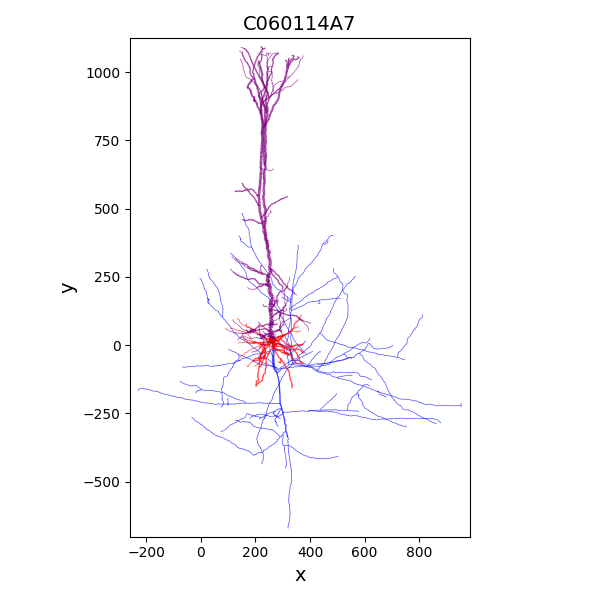

In [6]:
morphology_file = 'morphology/C060114A7.asc'

# Load morphology in NeuroM for visualization
nrn = neurom.load_neuron(morphology_file)
fig, _ = viewer.draw(nrn)
# Load morphology in BluePyOpt
morphology = ephys.morphologies.NrnFileMorphology(morphology_file)

Now we define the parameters, some of them are "**frozen**" (i.e. they are not going to be optimised), some are "**free**" (i.e. they are going to be optimised). In a typical biophysically detailed model the free parameters are the maximal conductances of the ionic currents (Na$^+$, K$^+$ and leak in this case) distributed in different compartments (soma, axon, dendrites).

In this example we insert the Na$^+$, K$^+$ and leak currents in the soma and leak current in all other compartments.

The membrane potential in the somatic location we are recording from is given by:

$$C_{m}\frac{dV}{dt} = I_{l} + I_{Na} + I_{K} $$

$$C_{m}\frac{dV}{dt} = \overline{g}_{l}(V-E_{l}) + \overline{g}_{Na}m^{3}h(V-E_{Na}) + \overline{g}_{K}n^{4}(V-E_{K}) $$

Where $\overline{g}_{l}$, $\overline{g}_{Na}$ and $\overline{g}_{k}$ are the maximal conductances. 

In this example, we are going to fit the passive properties of the cell model, by using the eFeatures extracted from the "LongStepNeg" stimulus. $E_{l}$ and $\overline{g}_{l}$ are going to be the free parameters. 

First of all, we need to distribute the HH mechanism in the somatic section. 

In [312]:
# Here we define a list of section, containing the neuron "soma"
somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')

hh_mech = ephys.mechanisms.NrnMODMechanism(                                         
        name='hh',                                                                  
        suffix='hh',                                                                
        locations=[somatic_loc])

# Leak conductance (Passive membrane resistance)
gl_param = ephys.parameters.NrnSectionParameter(                                    
        name='gl_hh',                                                           
        param_name='gl_hh',                                                     
        locations=[somatic_loc],                                                    
        bounds=[0, 1],
        frozen=False)  

# Reversal potential of leak conductance
el_param = ephys.parameters.NrnSectionParameter(                                    
        name='el_hh',                                                           
        param_name='el_hh',                                                     
        locations=[somatic_loc],                                                    
        bounds=[-90, -70],
        frozen=False)

# Na+ conductance
gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',                                                           
        param_name='gnabar_hh',                                                     
        locations=[somatic_loc],                                                    
        #bounds=[0, 1],
        value=0.0001,
        frozen=True)

# K+ conductance
gkbar_param = ephys.parameters.NrnSectionParameter(                              
        name='gkbar_hh',                                                         
        param_name='gkbar_hh',                                                   
        value=0.0003,
        #bounds=[0, 1],
        locations=[somatic_loc],                                                 
        frozen=True)


# Specific membrane capacitance
cm_param = ephys.parameters.NrnSectionParameter(                                 
        name='cm',                                                               
        param_name='cm',                                                         
        value=1.0,                                                               
        locations=[somatic_loc],                                                 
        frozen=True)

# Temperature (celsius)
celsius_param = ephys.parameters.NrnGlobalParameter(                                 
        name='celsius',                                                               
        param_name='celsius',                                                         
        value=34.0,                                                                 
        frozen=True)

# Voltage at time 0
vinit_param = ephys.parameters.NrnGlobalParameter(                                 
        name='v_init',                                                               
        param_name='v_init',                                                         
        value=-83,                                                                 
        frozen=True)   

To define the cell model, we specify the morphology, ion channels and parameters.

In [195]:
cell = ephys.models.CellModel(                                            
        name='cell',                                                      
        morph=morphology,                                                             
        mechs=[hh_mech],                                                         
        params=[cm_param, gnabar_param, gkbar_param, 
                gl_param, el_param, celsius_param, vinit_param])   
print cell

cell:
  morphology:
    morphology/C060114A7.asc
  mechanisms:
    hh: hh at ['somatic']
  params:
    cm: ['somatic'] cm = 1.0
    gnabar_hh: ['somatic'] gnabar_hh = 0.0001
    gkbar_hh: ['somatic'] gkbar_hh = 0.0003
    gl_hh: ['somatic'] gl_hh = [0, 1]
    el_hh: ['somatic'] el_hh = [-90, -70]
    celsius: celsius = 34.0
    v_init: v_init = -83



We define an object that point to the location of the soma. This will be useful to insert for example stimulation electrodes.

In [196]:
soma_loc = ephys.locations.NrnSeclistCompLocation(                               
        name='soma',                                                             
        seclist_name='somatic',                                                  
        sec_index=0,                                                             
        comp_x=0.5)         

# 2. Setting-up a simulation

To evaluate the behavior of the model, we need to setup a current stimulus and record the voltage response. 

We first try to fit the passive trace (negative current injection).

In [197]:
# Create a NEURON simulator object
nrn = ephys.simulators.NrnSimulator()                                            

# Current amplitudes (nA) used for the different protocols, 
# we have obtained them in the previous tutorial

LongStepPos = .98
LongStepNeg = -0.46
ShortStepPos = 0.85

# Collection of stimulus and recordings 
sweep_protocols = []

for protocol_name, amplitude in [('LongStepNeg', LongStepNeg)]:           
    stim = ephys.stimuli.NrnSquarePulse(                                         
                step_amplitude=amplitude,                                        
                step_delay=250,                                                  
                step_duration=3000,                                                
                location=soma_loc,                                               
                total_duration=3500)                                              
    rec = ephys.recordings.CompRecording(                                        
            name='%s.soma.v' % protocol_name,                                    
            location=soma_loc,                                                   
            variable='v')                                                        
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])       
    sweep_protocols.append(protocol)                                             

step_protocol = ephys.protocols.SequenceProtocol('LongStepNeg', protocols=sweep_protocols)
print step_protocol.protocols[0]

LongStepNeg:
  stimuli:
    Square pulse amp -0.460000 delay 250.000000 duration 3000.000000 totdur 3500.000000 at somatic[0](0.5)
  recordings:
    LongStepNeg.soma.v: v at somatic[0](0.5)



Not that we have create a protocol, we can run a simulation. To do so, we also need to assign a value to the free parameters.

In [297]:
%%time
# Assign a value to the parameter
default_params = {'gl_hh': 5e-4, 'el_hh' : -72}
test_responses = step_protocol.run(cell_model=cell, 
                                 param_values=default_params, sim=nrn)
print("Simulation finished.\n")

Simulation finished.

CPU times: user 8 ms, sys: 44 ms, total: 52 ms
Wall time: 569 ms


We can compare our initial model with the experimental data

<IPython.core.display.Javascript object>


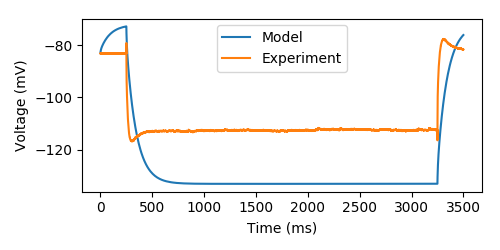

In [298]:
def plot_responses(responses):
    fig1, ax = plt.subplots(len(responses), figsize = (5, 2.5))
    ax.plot(responses['LongStepNeg.soma.v']['time'], responses['LongStepNeg.soma.v']['voltage'], 
            label='Model')
    
    data = numpy.fromfile(os.path.join("../eFEL/data/exp_IV_ch20_3026.dat"))
    data = data.reshape(len(data)/2,2)
            
    ax.plot(data[:, 0], data[:, 1], label='Experiment')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.legend(loc="best")
    fig1.tight_layout()
    
plot_responses(test_responses)


# 3. Setting up an evaluator

The "ephys" module containes helper functionality to define the objectives function and a scoring system that will be used by the [evolutionary algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm). We will use protocols and features to define the evaluator.

<IPython.core.display.Javascript object>


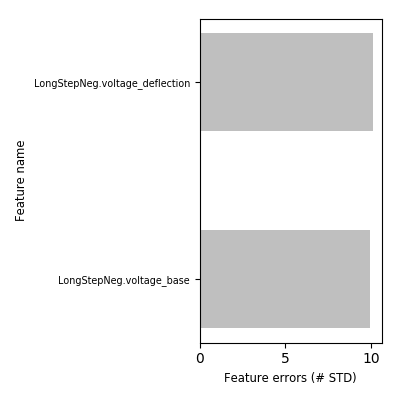

In [309]:
# Load json features file
with open("../eFEL/features.json", "r") as f:
    features = json.load(f)                               
                                
#efel_feature_means = features['LongStepNeg']                                                                             
objectives = []                                                                            
for protocol in sweep_protocols:                                                 
    stim_start = protocol.stimuli[0].step_delay                                  
    stim_end = stim_start + protocol.stimuli[0].step_duration 

    for efel_feature_name, mean_std_dict in features[protocol.name].items():
        mean = mean_std_dict['mean']
        std = mean_std_dict['std']
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        
        feature = ephys.efeatures.eFELFeature(                                   
                    feature_name,                                                
                    efel_feature_name=efel_feature_name,                         
                    recording_names={'': '%s.soma.v' % protocol.name},           
                    stim_start=stim_start,                                       
                    stim_end=stim_end,                                           
                    exp_mean=mean,                                               
                    exp_std=std)
        
        objective = ephys.objectives.SingletonObjective(                         
            feature_name,                                                        
            feature)                                                             
        objectives.append(objective)         
        
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives)        

cell_evaluator = ephys.evaluators.CellEvaluator(                                 
        cell_model=cell,                                                  
        param_names=['gl_hh', 'el_hh'],                                   
        fitness_protocols={twostep_protocol.name: step_protocol},             
        fitness_calculator=score_calc,                                           
        sim=nrn)        

def plot_objectives(objectives):
    ytick_pos = [x + 0.5 for x in range(len(objectives))]
    obj_val = objectives.values()
    obj_keys = objectives.keys()
    fig, ax = plt.subplots(figsize = (4,4))
    ax.barh(ytick_pos,
              obj_val,
              height=0.5,
              align='center',
              color='gray',
              alpha=0.5,
              label=" Sum: %0.2f"%sv)
    ax.set_yticks(ytick_pos)
    ax.set_ylabel("Feature name", size = "small")
    ax.set_xlabel("Feature errors (# STD)", size = "small")
    ax.set_yticklabels(obj_keys, size='x-small')
    fig.tight_layout()
       
objectives = cell_evaluator.evaluate_with_dicts(default_params)
plot_objectives(objectives)

# 4. Parameters optimization 
We are now ready to run an optimisation. This procedure could require supercomputing resources and can take from some hours to days. As a proof of concept, we will run an optimization with a small population of individuals for a small number of generations.

In [231]:
optimisation = bpopt.optimisations.DEAPOptimisation(                              
        evaluator=cell_evaluator,                                                
        offspring_size = 15)    

In [232]:
%%time
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=14)               


CPU times: user 14.4 s, sys: 5.22 s, total: 19.7 s
Wall time: 2min 6s


After 7 generations, the model passive responses are fairly satisfying.

<IPython.core.display.Javascript object>


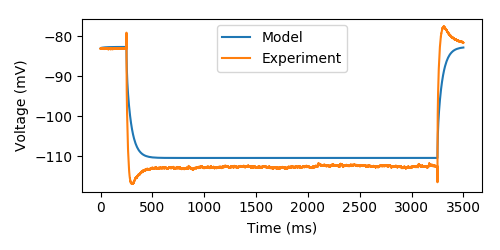

In [244]:
responses = step_protocol.run(cell_model=cell, 
                                 param_values=cell_evaluator.param_dict(hall_of_fame[0]), sim=nrn)
plot_responses(responses)

# 5. Optimisation results

After running an optimisation, we can inspect the 10 best inviduals, or **"Hall of Fame"**. In our case it contains values for the parameter $\bar{g}_{leak}$ and ${E}_{leak}$.

<IPython.core.display.Javascript object>


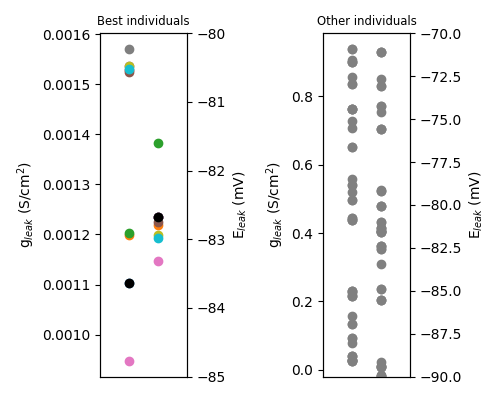

In [287]:
fig, axs = plt.subplots(1,2, figsize = (5,4))
      
ax0 = axs[0].twinx()
ax0.set_ylabel("E$_{leak}$ (mV)")
for param_set in hall_of_fame:
    axs[0].plot(0, param_set[0], "o")    
    ax0.set_ylim([-85,-80])
    ax0.plot(1, param_set[1], "o")
    axs[0].set_title("Best individuals", fontsize = "small")

ax1 = axs[1].twinx()
ax1.set_ylabel("E$_{leak}$ (mV)")
ax1.set_ylim([el_param.lower_bound, el_param.upper_bound])
for param_set in hist.genealogy_history.values()[:50]:
        axs[1].plot(0,param_set[0], "o", color = "gray")
        ax1.plot(1,param_set[1], "o", color = "gray")
        axs[1].set_title("Other individuals", fontsize = "small")
      
for ax in axs:
    ax.set_xlim([-1,2])
    ax.set_xticks([])
    ax.set_ylabel("g$_{leak}$ (S/cm$^2$)")   
    
fig.tight_layout()    


The best individual from the optimisation is the first one in the hall of fame.

In [288]:
best_ind = hall_of_fame[0]

axs[0].plot(0, best_ind[0], "o", color='k')    
ax0.plot(1, best_ind[1], "o", color = 'k')
#axs[0].set_title("Best individuals", fontsize = "small")

print 'Best individual: {} '.format(best_ind)


Best individual: [0.0011037078860466152, -82.68088648004289] 


We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dictionary of the scores (the lower, the better).

<IPython.core.display.Javascript object>


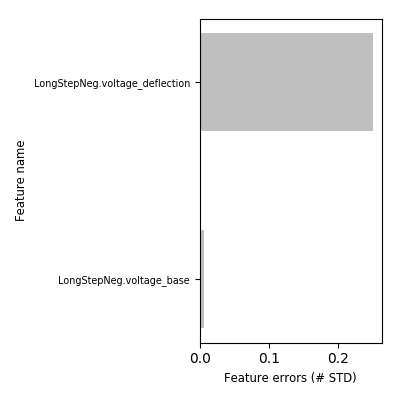

In [302]:
best_ind_dict = cell_evaluator.param_dict(best_ind)                              
objectives =  cell_evaluator.evaluate_with_dicts(best_ind_dict)

plot_objectives(objectives)

We can also plot the evolution of the feature errors from generation to generation. We can observe a progressive convergence of the model features values toward the experimental ones.

<IPython.core.display.Javascript object>


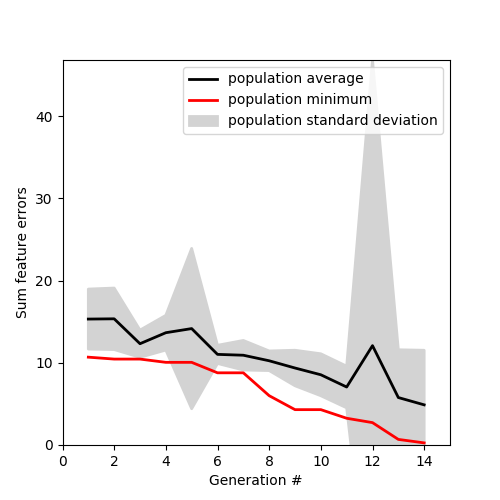

In [311]:
gen_numbers = logs.select('gen')
min_fitness = numpy.array(logs.select('min'))
max_fitness = logs.select('max')
mean_fitness = numpy.array(logs.select('avg'))
std_fitness = numpy.array(logs.select('std'))

fig, ax = plt.subplots(1, figsize=(5, 5), facecolor='white')
#fig_trip, ax_trip = plt.subplots(1, figsize=(10, 5), facecolor='white')

stdminus = mean_fitness - std_fitness                                                           
stdplus = mean_fitness + std_fitness

ax.plot(gen_numbers, mean_fitness, color='black', linewidth=2, 
        label='population average')                                                 

ax.fill_between(gen_numbers, stdminus, stdplus, color='lightgray', linewidth=2,                                                                
    label=r'population standard deviation')                                     

ax.plot(gen_numbers, min_fitness, color='red', linewidth=2, label='population minimum')                                                 

ax.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)                       
ax.set_xlabel('Generation #')                                                 
ax.set_ylabel('Sum feature errors')                                            
ax.set_ylim([0, max(stdplus)])                                                
ax.legend(loc="best") 